<a href="https://colab.research.google.com/github/alsedawy/sedawy/blob/main/%D9%8CResearch_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
from transformers import pipeline
from datasets import Dataset

from langchain_community.llms import HuggingFacePipeline
from langchain_community.document_loaders import TextLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter

from langchain_community.embeddings import SentenceTransformerEmbeddings
from langchain_community.vectorstores import Chroma

from langchain_core.prompts import ChatPromptTemplate

from ragas import evaluate
from ragas.metrics import faithfulness, answer_relevancy, context_precision

# ================= LLM =================
hf_pipeline = pipeline("text2text-generation", model="google/flan-t5-base")
llm = HuggingFacePipeline(pipeline=hf_pipeline)

def safe_invoke(text):
    res = llm.invoke(text)
    if isinstance(res, dict):
        return res.get("text", "")
    return str(res)

# ================= Load Data =================
loader = TextLoader("IT_Q&A.txt", encoding="latin-1")
documents = loader.load()

splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50)
texts = splitter.split_documents(documents)

# ================= Embeddings =================
embeddings = SentenceTransformerEmbeddings(
    model_name="all-MiniLM-L6-v2"
)

# ================= Vector DB (Chroma) =================
vectorstore = Chroma.from_documents(
    texts,
    embedding=embeddings
)

retriever = vectorstore.as_retriever(search_kwargs={"k": 5})

# ================= Prompt =================
template = """Answer only from the context.

Question: {question}
Context: {context}
"""
prompt = ChatPromptTemplate.from_template(template)

# ================= Fusion Utilities =================
def rrf(results, k=60):
    scores = {}
    for docs in results:
        for rank, doc in enumerate(docs):
            c = doc.page_content
            scores[c] = scores.get(c, 0) + 1/(k+rank+1)
    return sorted(scores.items(), key=lambda x: x[1], reverse=True)

# ================= RAG Normal =================
def rag_normal(question: str):
    docs = retriever.invoke(question)
    context = "\n".join([d.page_content for d in docs])

    p = prompt.format_prompt(question=question, context=context)
    return safe_invoke(p.to_string())

# ================= RAG Fusion =================
def rag_fusion(question: str):
    queries = [question]

    results = []
    for q in queries:
        docs = retriever.invoke(q)
        results.append(docs)

    fused = rrf(results)
    contexto = "\n".join([doc for doc, _ in fused[:5]])

    p = prompt.format_prompt(question=question, context=contexto)
    return safe_invoke(p.to_string())

# ================= Test =================
print(rag_fusion("What are the steps to secure a Wi-Fi network?"))

# ================= RAGAS Dataset =================
questions = [
    "What are the steps to secure a Wi-Fi network?",
    "How can I protect my computer from malware?",
    "What is phishing and how to avoid it?"
]

ground_truths = [
    "Change default passwords, use WPA3, disable WPS, enable firewall.",
    "Install antivirus, update software, avoid suspicious links.",
    "Phishing is a social engineering attack, avoid suspicious emails."
]

normal_answers = []
fusion_answers = []
contexts = []

for q in questions:
    docs = retriever.invoke(q)
    context = "\n".join([d.page_content for d in docs])
    contexts.append([context])

    normal_answers.append(rag_normal(q))
    fusion_answers.append(rag_fusion(q))

dataset_normal = Dataset.from_dict({
    "question": questions,
    "answer": normal_answers,
    "contexts": contexts,
    "ground_truth": ground_truths
})

dataset_fusion = Dataset.from_dict({
    "question": questions,
    "answer": fusion_answers,
    "contexts": contexts,
    "ground_truth": ground_truths
})

from ragas.llms.base import BaseRagasLLM
from langchain_core.outputs import LLMResult, Generation

class HFLLM(BaseRagasLLM):
    def __init__(self, llm):
        self.llm = llm

    def generate_text(self, prompts, **kwargs):
        results = []
        for p in prompts:
            res = safe_invoke(p)
            results.append(
                LLMResult(generations=[[Generation(text=res)]])
            )
        return results

    async def agenerate_text(self, prompts, **kwargs):
        return self.generate_text(prompts, **kwargs)

    def is_finished(self, response):
        return True


from ragas.embeddings.base import BaseRagasEmbeddings

class HFEmbeddings(BaseRagasEmbeddings):
    def __init__(self, embedder):
        self.embedder = embedder

    def embed_documents(self, texts):
        return self.embedder.embed_documents(texts)

    def embed_query(self, text):
        return self.embedder.embed_query(text)

    async def aembed_documents(self, texts):
        return self.embed_documents(texts)

    async def aembed_query(self, text):
        return self.embed_query(text)
ragas_llm = HFLLM(llm)
ragas_embeddings = HFEmbeddings(embeddings)


# ================= RAGAS Evaluation =================
results_normal = evaluate(
    dataset_normal,
    metrics=[faithfulness, answer_relevancy, context_precision],
    llm=ragas_llm,
    embeddings=ragas_embeddings
)



print("✅ Normal RAG Results:", results_normal)

results_fusion = evaluate(
    dataset_fusion,
    metrics=[faithfulness, answer_relevancy, context_precision],
    llm=ragas_llm,
    embeddings=ragas_embeddings
)

print("✅ Fusion RAG Results:", results_fusion)


Device set to use cuda:0


Strong Passwords and Encryption: It is always recommended creating a password that is very hard to crack as well as unique. Use WPA2 encryption on your Wi-Fi network.


Token indices sequence length is longer than the specified maximum sequence length for this model (528 > 512). Running this sequence through the model will result in indexing errors


Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

ERROR:ragas.executor:Exception raised in Job[7]: TypeError(HFLLM.agenerate_text() missing 1 required positional argument: 'prompts')
ERROR:ragas.executor:Exception raised in Job[4]: TypeError(HFLLM.agenerate_text() missing 1 required positional argument: 'prompts')
ERROR:ragas.executor:Exception raised in Job[0]: TypeError(HFLLM.agenerate_text() missing 1 required positional argument: 'prompts')
ERROR:ragas.executor:Exception raised in Job[5]: TypeError(HFLLM.agenerate_text() missing 1 required positional argument: 'prompts')
ERROR:ragas.executor:Exception raised in Job[6]: TypeError(HFLLM.agenerate_text() missing 1 required positional argument: 'prompts')
ERROR:ragas.executor:Exception raised in Job[2]: TypeError(HFLLM.agenerate_text() missing 1 required positional argument: 'prompts')
ERROR:ragas.executor:Exception raised in Job[8]: TypeError(HFLLM.agenerate_text() missing 1 required positional argument: 'prompts')
ERROR:ragas.executor:Exception raised in Job[1]: TypeError(HFLLM.agen

✅ Normal RAG Results: {'faithfulness': nan, 'answer_relevancy': nan, 'context_precision': nan}


Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

ERROR:ragas.executor:Exception raised in Job[8]: TypeError(HFLLM.agenerate_text() missing 1 required positional argument: 'prompts')
ERROR:ragas.executor:Exception raised in Job[6]: TypeError(HFLLM.agenerate_text() missing 1 required positional argument: 'prompts')
ERROR:ragas.executor:Exception raised in Job[2]: TypeError(HFLLM.agenerate_text() missing 1 required positional argument: 'prompts')
ERROR:ragas.executor:Exception raised in Job[4]: TypeError(HFLLM.agenerate_text() missing 1 required positional argument: 'prompts')
ERROR:ragas.executor:Exception raised in Job[3]: TypeError(HFLLM.agenerate_text() missing 1 required positional argument: 'prompts')
ERROR:ragas.executor:Exception raised in Job[1]: TypeError(HFLLM.agenerate_text() missing 1 required positional argument: 'prompts')
ERROR:ragas.executor:Exception raised in Job[0]: TypeError(HFLLM.agenerate_text() missing 1 required positional argument: 'prompts')
ERROR:ragas.executor:Exception raised in Job[5]: TypeError(HFLLM.agen

✅ Fusion RAG Results: {'faithfulness': nan, 'answer_relevancy': nan, 'context_precision': nan}


In [9]:
!pip uninstall -y -q numpy langchain langchain-core langchain-community ragas
!pip install -q numpy==1.26.4

!pip install -q \
langchain==0.1.14 \
langchain-core==0.1.35 \
langchain-community==0.0.30 \
chromadb \
sentence-transformers \
transformers \
accelerate \
datasets \
ragas==0.1.7

import re
from datasets import Dataset
from transformers import pipeline

from langchain_community.llms import HuggingFacePipeline
from langchain_community.document_loaders import TextLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.embeddings import HuggingFaceBgeEmbeddings
from langchain_community.vectorstores import Chroma

from langchain_core.prompts import ChatPromptTemplate
from langchain_core.outputs import LLMResult, Generation

from ragas import evaluate
from ragas.metrics import faithfulness, answer_relevancy, context_precision
from ragas.llms.base import BaseRagasLLM
from ragas.embeddings.base import BaseRagasEmbeddings

hf_pipeline = pipeline("text2text-generation", model="google/flan-t5-base")
llm = HuggingFacePipeline(pipeline=hf_pipeline)

def safe_invoke(text):
    res = llm.invoke(text)
    if isinstance(res, dict):
        return res.get("text", "")
    return str(res)

loader = TextLoader("IT_Q&A.txt", encoding="latin-1")
documents = loader.load()

text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50)
texts = text_splitter.split_documents(documents)

embeddings = HuggingFaceBgeEmbeddings(model_name="BAAI/bge-small-en-v1.5")

vectorstore = Chroma.from_documents(
    texts,
    embedding=embeddings
)

retriever = vectorstore.as_retriever(search_kwargs={"k": 5})

template = """Answer using only the context below.

Question: {question}
Context: {context}
"""
prompt = ChatPromptTemplate.from_template(template)

def rewrite_query(question: str) -> str:
    return safe_invoke(f"Rewrite this question clearly:\n{question}")

def multi_queries(q: str, n=3):
    text = safe_invoke(f"Generate {n} search queries:\n{q}")
    qs = [x.strip() for x in text.split("\n") if len(x.strip()) > 5]
    return qs if qs else [q]

def rrf(results, k=60):
    scores = {}
    for _, docs in results.items():
        for rank, doc in enumerate(docs):
            content = doc.page_content
            scores[content] = scores.get(content, 0) + 1 / (k + rank + 1)
    return sorted(scores.items(), key=lambda x: x[1], reverse=True)

def enhanced_retrieve(question: str):
    rq = rewrite_query(question)
    queries = multi_queries(rq)

    results = {}
    for q in queries:
        docs = retriever.invoke(q)
        results[q] = docs

    fused = rrf(results)
    return "\n".join([doc for doc, _ in fused[:5]])

def rag_normal(question: str):
    docs = retriever.invoke(question)
    context = "\n".join([d.page_content for d in docs])

    final_prompt = prompt.format_prompt(
        question=question,
        context=context
    )
    return safe_invoke(final_prompt.to_string())

def rag_fusion(question: str):
    context = enhanced_retrieve(question)

    final_prompt = prompt.format_prompt(
        question=question,
        context=context
    )
    return safe_invoke(final_prompt.to_string())

print("✅ Fusion Answer:\n")
print(rag_fusion("What are the steps to secure a Wi-Fi network?"))

questions = [
    "What are the steps to secure a Wi-Fi network?",
    "How can I protect my computer from malware?",
    "What is phishing and how to avoid it?"
]

ground_truths = [
    "Change default passwords, use WPA3, disable WPS, enable firewall.",
    "Install antivirus, update software, avoid suspicious links.",
    "Phishing is a social engineering attack, avoid suspicious emails."
]

normal_answers = []
fusion_answers = []
contexts_list = []

for q in questions:
    docs = retriever.invoke(q)
    context = "\n".join([d.page_content for d in docs])

    normal_answers.append(rag_normal(q))
    fusion_answers.append(rag_fusion(q))
    contexts_list.append([context])

dataset_normal = Dataset.from_dict({
    "question": questions,
    "answer": normal_answers,
    "contexts": contexts_list,
    "ground_truth": ground_truths
})

dataset_fusion = Dataset.from_dict({
    "question": questions,
    "answer": fusion_answers,
    "contexts": contexts_list,
    "ground_truth": ground_truths
})


class HFLLM(BaseRagasLLM):
    def __init__(self, llm):
        self.llm = llm

    def generate_text(self, prompt: str):
        return safe_invoke(prompt)

    async def agenerate_text(self, prompt: str):
        return self.generate_text(prompt)

    def is_finished(self):
        return True


class HFEmbeddings(BaseRagasEmbeddings):
    def __init__(self, embedder):
        self.embedder = embedder

    def embed_documents(self, texts):
        return self.embedder.embed_documents(texts)

    def embed_query(self, text):
        return self.embedder.embed_query(text)

    async def aembed_documents(self, texts):
        return self.embed_documents(texts)

    async def aembed_query(self, text):
        return self.embed_query(text)

ragas_llm = HFLLM(llm)
ragas_embeddings = HFEmbeddings(embeddings)

results_normal = evaluate(
    dataset_normal,
    metrics=[faithfulness, answer_relevancy, context_precision],
    llm=ragas_llm,
    embeddings=ragas_embeddings
)

results_fusion = evaluate(
    dataset_fusion,
    metrics=[faithfulness, answer_relevancy, context_precision],
    llm=ragas_llm,
    embeddings=ragas_embeddings
)

print("✅ Normal RAG Scores:\n", results_normal)
print("\n✅ Fusion RAG Scores:\n", results_fusion)



# ==== تجهيز نتائج الجراف الأول (Rewrite vs Fusion) ====

rewrite_scores = [
    float(np.mean(results_rewrite["faithfulness"])),
    float(np.mean(results_rewrite["answer_relevancy"])),
    float(np.mean(results_rewrite["context_precision"]))
]

fusion_scores_cmp = [
    float(np.mean(results_fusion["faithfulness"])),
    float(np.mean(results_fusion["answer_relevancy"])),
    float(np.mean(results_fusion["context_precision"]))
]
plt.figure()
plt.plot(rewrite_scores)
plt.plot(fusion_scores_cmp)
plt.xticks(range(3), ["Faithfulness", "Answer Relevancy", "Context Precision"])
plt.title("Query Rewriting vs Retrieval Fusion")
plt.show()
normal_scores = [
    float(np.mean(results_normal["faithfulness"])),
    float(np.mean(results_normal["answer_relevancy"])),
    float(np.mean(results_normal["context_precision"]))
]

fusion_scores = [
    float(np.mean(results_fusion["faithfulness"])),
    float(np.mean(results_fusion["answer_relevancy"])),
    float(np.mean(results_fusion["context_precision"]))
]
plt.figure()
plt.bar(range(3), normal_scores)
plt.bar(range(3), fusion_scores)
plt.xticks(range(3), ["Faithfulness", "Answer Relevancy", "Context Precision"])
plt.title("Normal RAG vs Fusion RAG")
plt.show()


import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline
print("Normal Faithfulness:", results_normal["faithfulness"][:5])
print("Fusion Faithfulness:", results_fusion["faithfulness"][:5])


def avg(x):
    return float(np.mean(x))

normal_scores = [
    avg(results_normal["faithfulness"]),
    avg(results_normal["answer_relevancy"]),
    avg(results_normal["context_precision"])
]

fusion_scores = [
    avg(results_fusion["faithfulness"]),
    avg(results_fusion["answer_relevancy"]),
    avg(results_fusion["context_precision"])
]

metrics = ["Faithfulness", "Answer Relevancy", "Context Precision"]
x = range(len(metrics))

plt.figure()
plt.bar(x, normal_scores)
plt.bar(x, fusion_scores)
plt.xticks(x, metrics)
plt.title("Normal RAG vs Fusion RAG")
plt.show()


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pytensor 2.35.1 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
shap 0.50.0 requires numpy>=2, but you have numpy 1.26.4 which is incompatible.
jaxlib 0.7.2 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
jax 0.7.2 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
ERROR: Cannot install langchain-core==0.1.35 and langchain==0.1.14 because these package versions have conf

Device set to use cuda:0


✅ Fusion Answer:



Token indices sequence length is longer than the specified maximum sequence length for this model (554 > 512). Running this sequence through the model will result in indexing errors


Strong Passwords and Encryption: It is always recommended creating a password that is very hard to crack as well as unique. Use WPA2 encryption on your Wi-Fi network.


Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

ERROR:ragas.executor:Exception raised in Job[0]: TypeError(HFLLM.agenerate_text() got an unexpected keyword argument 'n')
ERROR:ragas.executor:Exception raised in Job[4]: TypeError(HFLLM.agenerate_text() got an unexpected keyword argument 'n')
ERROR:ragas.executor:Exception raised in Job[6]: TypeError(HFLLM.agenerate_text() got an unexpected keyword argument 'n')
ERROR:ragas.executor:Exception raised in Job[5]: TypeError(HFLLM.agenerate_text() got an unexpected keyword argument 'n')
ERROR:ragas.executor:Exception raised in Job[7]: TypeError(HFLLM.agenerate_text() got an unexpected keyword argument 'n')
ERROR:ragas.executor:Exception raised in Job[2]: TypeError(HFLLM.agenerate_text() got an unexpected keyword argument 'n')
ERROR:ragas.executor:Exception raised in Job[3]: TypeError(HFLLM.agenerate_text() got an unexpected keyword argument 'n')
ERROR:ragas.executor:Exception raised in Job[1]: TypeError(HFLLM.agenerate_text() got an unexpected keyword argument 'n')
ERROR:ragas.executor:Exc

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

ERROR:ragas.executor:Exception raised in Job[5]: TypeError(HFLLM.agenerate_text() got an unexpected keyword argument 'n')
ERROR:ragas.executor:Exception raised in Job[7]: TypeError(HFLLM.agenerate_text() got an unexpected keyword argument 'n')
ERROR:ragas.executor:Exception raised in Job[1]: TypeError(HFLLM.agenerate_text() got an unexpected keyword argument 'n')
ERROR:ragas.executor:Exception raised in Job[3]: TypeError(HFLLM.agenerate_text() got an unexpected keyword argument 'n')
ERROR:ragas.executor:Exception raised in Job[6]: TypeError(HFLLM.agenerate_text() got an unexpected keyword argument 'n')
ERROR:ragas.executor:Exception raised in Job[2]: TypeError(HFLLM.agenerate_text() got an unexpected keyword argument 'n')
ERROR:ragas.executor:Exception raised in Job[4]: TypeError(HFLLM.agenerate_text() got an unexpected keyword argument 'n')
ERROR:ragas.executor:Exception raised in Job[0]: TypeError(HFLLM.agenerate_text() got an unexpected keyword argument 'n')
ERROR:ragas.executor:Exc

✅ Normal RAG Scores:
 {'faithfulness': nan, 'answer_relevancy': nan, 'context_precision': nan}

✅ Fusion RAG Scores:
 {'faithfulness': nan, 'answer_relevancy': nan, 'context_precision': nan}


NameError: name 'results_rewrite' is not defined

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pytensor 2.35.1 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
shap 0.50.0 requires numpy>=2, but you have numpy 1.26.4 which is incompatible.
jaxlib 0.7.2 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
jax 0.7.2 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
ERROR: Cannot install langchain-core==0.1.35 and langchain==0.1.14 because these package versions have conf

Device set to use cuda:0
Token indices sequence length is longer than the specified maximum sequence length for this model (554 > 512). Running this sequence through the model will result in indexing errors


Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

ERROR:ragas.executor:Exception raised in Job[1]: TypeError(HFLLM.agenerate_text() got an unexpected keyword argument 'n')
ERROR:ragas.executor:Exception raised in Job[6]: TypeError(HFLLM.agenerate_text() got an unexpected keyword argument 'n')
ERROR:ragas.executor:Exception raised in Job[2]: TypeError(HFLLM.agenerate_text() got an unexpected keyword argument 'n')
ERROR:ragas.executor:Exception raised in Job[4]: TypeError(HFLLM.agenerate_text() got an unexpected keyword argument 'n')
ERROR:ragas.executor:Exception raised in Job[8]: TypeError(HFLLM.agenerate_text() got an unexpected keyword argument 'n')
ERROR:ragas.executor:Exception raised in Job[5]: TypeError(HFLLM.agenerate_text() got an unexpected keyword argument 'n')
ERROR:ragas.executor:Exception raised in Job[7]: TypeError(HFLLM.agenerate_text() got an unexpected keyword argument 'n')
ERROR:ragas.executor:Exception raised in Job[3]: TypeError(HFLLM.agenerate_text() got an unexpected keyword argument 'n')
ERROR:ragas.executor:Exc

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

ERROR:ragas.executor:Exception raised in Job[0]: TypeError(HFLLM.agenerate_text() got an unexpected keyword argument 'n')
ERROR:ragas.executor:Exception raised in Job[5]: TypeError(HFLLM.agenerate_text() got an unexpected keyword argument 'n')
ERROR:ragas.executor:Exception raised in Job[8]: TypeError(HFLLM.agenerate_text() got an unexpected keyword argument 'n')
ERROR:ragas.executor:Exception raised in Job[6]: TypeError(HFLLM.agenerate_text() got an unexpected keyword argument 'n')
ERROR:ragas.executor:Exception raised in Job[7]: TypeError(HFLLM.agenerate_text() got an unexpected keyword argument 'n')
ERROR:ragas.executor:Exception raised in Job[1]: TypeError(HFLLM.agenerate_text() got an unexpected keyword argument 'n')
ERROR:ragas.executor:Exception raised in Job[4]: TypeError(HFLLM.agenerate_text() got an unexpected keyword argument 'n')
ERROR:ragas.executor:Exception raised in Job[3]: TypeError(HFLLM.agenerate_text() got an unexpected keyword argument 'n')
ERROR:ragas.executor:Exc

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

ERROR:ragas.executor:Exception raised in Job[1]: TypeError(HFLLM.agenerate_text() got an unexpected keyword argument 'n')
ERROR:ragas.executor:Exception raised in Job[7]: TypeError(HFLLM.agenerate_text() got an unexpected keyword argument 'n')
ERROR:ragas.executor:Exception raised in Job[4]: TypeError(HFLLM.agenerate_text() got an unexpected keyword argument 'n')
ERROR:ragas.executor:Exception raised in Job[0]: TypeError(HFLLM.agenerate_text() got an unexpected keyword argument 'n')
ERROR:ragas.executor:Exception raised in Job[8]: TypeError(HFLLM.agenerate_text() got an unexpected keyword argument 'n')
ERROR:ragas.executor:Exception raised in Job[6]: TypeError(HFLLM.agenerate_text() got an unexpected keyword argument 'n')
ERROR:ragas.executor:Exception raised in Job[3]: TypeError(HFLLM.agenerate_text() got an unexpected keyword argument 'n')
ERROR:ragas.executor:Exception raised in Job[5]: TypeError(HFLLM.agenerate_text() got an unexpected keyword argument 'n')
ERROR:ragas.executor:Exc

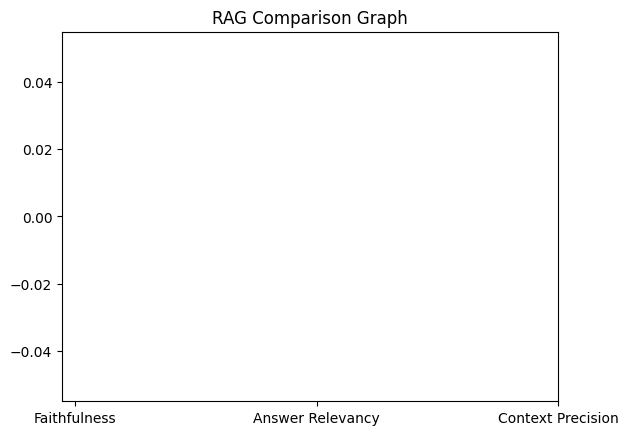

Normal: [nan, nan, nan]
Rewrite: [nan, nan, nan]
Fusion: [nan, nan, nan]


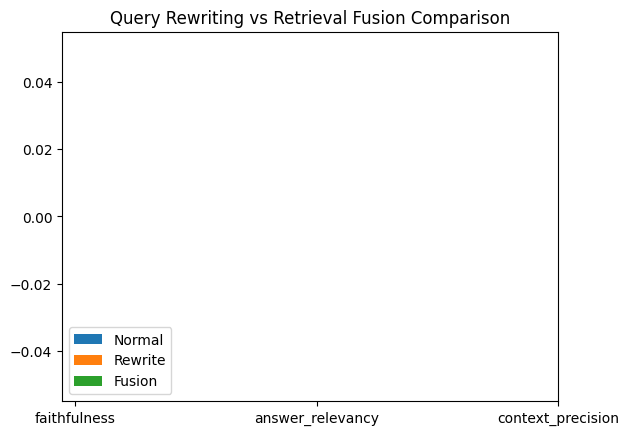

In [14]:
!pip uninstall -y -q numpy langchain langchain-core langchain-community ragas
!pip install -q numpy==1.26.4

!pip install -q \
langchain==0.1.14 \
langchain-core==0.1.35 \
langchain-community==0.0.30 \
chromadb \
sentence-transformers \
transformers \
accelerate \
datasets \
ragas==0.1.7

import re
import numpy as np
import matplotlib.pyplot as plt
from datasets import Dataset
from transformers import pipeline

from langchain_community.llms import HuggingFacePipeline
from langchain_community.document_loaders import TextLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.embeddings import HuggingFaceBgeEmbeddings
from langchain_community.vectorstores import Chroma

from langchain_core.prompts import ChatPromptTemplate

from ragas import evaluate
from ragas.metrics import faithfulness, answer_relevancy, context_precision
from ragas.llms.base import BaseRagasLLM
from ragas.embeddings.base import BaseRagasEmbeddings

%matplotlib inline

hf_pipeline = pipeline("text2text-generation", model="google/flan-t5-base")
llm = HuggingFacePipeline(pipeline=hf_pipeline)

def safe_invoke(text):
    out = llm.invoke(text)
    if isinstance(out, dict):
        return out.get("text", "")
    return str(out)

loader = TextLoader("IT_Q&A.txt", encoding="latin-1")
documents = loader.load()

splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50)
texts = splitter.split_documents(documents)

embeddings = HuggingFaceBgeEmbeddings(model_name="BAAI/bge-small-en-v1.5")

vectorstore = Chroma.from_documents(texts, embedding=embeddings)
retriever = vectorstore.as_retriever(search_kwargs={"k": 5})

prompt = ChatPromptTemplate.from_template("""
Answer using only the context below.

Question: {question}
Context: {context}
""")

def rewrite_query(q):
    return safe_invoke(f"Rewrite this question clearly:\n{q}")

def multi_queries(q, n=3):
    txt = safe_invoke(f"Generate {n} search queries:\n{q}")
    qs = [x for x in txt.split('\n') if len(x.strip()) > 5]
    return qs if qs else [q]

def rrf(results, k=60):
    scores = {}
    for docs in results.values():
        for rank, doc in enumerate(docs):
            c = doc.page_content
            scores[c] = scores.get(c, 0) + 1/(k+rank+1)
    return sorted(scores.items(), key=lambda x: x[1], reverse=True)

def enhanced_retrieve(q):
    rq = rewrite_query(q)
    queries = multi_queries(rq)

    results = {}
    for query in queries:
        docs = retriever.invoke(query)
        results[query] = docs

    fused = rrf(results)
    return "\n".join([doc for doc,_ in fused[:5]])

def rag_normal(q):
    docs = retriever.invoke(q)
    ctx = "\n".join([d.page_content for d in docs])
    p = prompt.format_prompt(question=q, context=ctx)
    return safe_invoke(p.to_string())

def rag_query(q):
    rq = rewrite_query(q)
    docs = retriever.invoke(rq)
    ctx = "\n".join([d.page_content for d in docs])
    p = prompt.format_prompt(question=q, context=ctx)
    return safe_invoke(p.to_string())

def rag_fusion(q):
    ctx = enhanced_retrieve(q)
    p = prompt.format_prompt(question=q, context=ctx)
    return safe_invoke(p.to_string())

questions = [
    "What are the steps to secure a Wi-Fi network?",
    "How can I protect my computer from malware?",
    "What is phishing and how to avoid it?"
]

ground_truths = [
    "Change default passwords, use WPA3, disable WPS, enable firewall.",
    "Install antivirus, update software, avoid suspicious links.",
    "Phishing is a social engineering attack, avoid suspicious emails."
]

normal_answers = []
rewrite_answers = []
fusion_answers = []
contexts = []

for q in questions:
    docs = retriever.invoke(q)
    ctx = "\n".join([d.page_content for d in docs])
    contexts.append([ctx])

    normal_answers.append(rag_normal(q))
    rewrite_answers.append(rag_query(q))
    fusion_answers.append(rag_fusion(q))

dataset_normal = Dataset.from_dict({
    "question": questions,
    "answer": normal_answers,
    "contexts": contexts,
    "ground_truth": ground_truths
})

dataset_rewrite = Dataset.from_dict({
    "question": questions,
    "answer": rewrite_answers,
    "contexts": contexts,
    "ground_truth": ground_truths
})

dataset_fusion = Dataset.from_dict({
    "question": questions,
    "answer": fusion_answers,
    "contexts": contexts,
    "ground_truth": ground_truths
})

from ragas.llms.base import BaseRagasLLM

class HFLLM(BaseRagasLLM):
    def __init__(self, llm):
        self.llm = llm

    def generate_text(self, prompt, callbacks=None):
        return self.llm.invoke(prompt)

    async def agenerate_text(self, prompt, callbacks=None):
        return self.generate_text(prompt)

    def is_finished(self, response):
        return True


from ragas.embeddings.base import BaseRagasEmbeddings

class HFEmbeddings(BaseRagasEmbeddings):
    def __init__(self, embedder):
        self.embedder = embedder

    def embed_query(self, text):
        return self.embedder.embed_query(text)

    def embed_documents(self, texts):
        return self.embedder.embed_documents(texts)

    async def aembed_query(self, text):
        return self.embed_query(text)

    async def aembed_documents(self, texts):
        return self.embed_documents(texts)


ragas_llm = HFLLM(llm)
ragas_embeddings = HFEmbeddings(embeddings)

results_normal = evaluate(dataset_normal, [faithfulness, answer_relevancy, context_precision],
                          llm=ragas_llm, embeddings=ragas_embeddings)

results_rewrite = evaluate(dataset_rewrite, [faithfulness, answer_relevancy, context_precision],
                           llm=ragas_llm, embeddings=ragas_embeddings)

results_fusion = evaluate(dataset_fusion, [faithfulness, answer_relevancy, context_precision],
                          llm=ragas_llm, embeddings=ragas_embeddings)



def avg(x):
    import numpy as np
    return float(np.mean(x))

metrics = ["faithfulness", "answer_relevancy", "context_precision"]

import numpy as np

def safe_scores(results, metric_name):
    # RAGAS sometimes returns list[dict]
    scores = results.scores

    if isinstance(scores, list) and len(scores) > 0:
        if isinstance(scores[0], dict):
            return float(np.mean(scores[0][metric_name]))

    # fallback
    return float(np.mean(scores))

metrics = ["faithfulness", "answer_relevancy", "context_precision"]

norm = [safe_scores(results_normal, m) for m in metrics]
rewr = [safe_scores(results_rewrite, m) for m in metrics]
fuse = [safe_scores(results_fusion, m) for m in metrics]





labels = ["Faithfulness", "Answer Relevancy", "Context Precision"]
x = np.arange(len(labels))

plt.figure()
plt.plot(x, norm)
plt.plot(x, rewr)
plt.plot(x, fuse)
plt.xticks(x, labels)
plt.title("RAG Comparison Graph")
plt.show()

import numpy as np

def get_scores(results, name):
    scores_block = results.scores

    if isinstance(scores_block, list) and isinstance(scores_block[0], dict):
        values = scores_block[0][name]
    elif isinstance(scores_block, dict):
        values = scores_block[name]
    else:
        values = scores_block

    return float(np.mean(values))

metrics = ["faithfulness", "answer_relevancy", "context_precision"]

norm = [get_scores(results_normal, m) for m in metrics]
rewr = [get_scores(results_rewrite, m) for m in metrics]
fuse = [get_scores(results_fusion, m) for m in metrics]

print("Normal:", norm)
print("Rewrite:", rewr)
print("Fusion:", fuse)

import matplotlib.pyplot as plt
import numpy as np

x = np.arange(len(metrics))
width = 0.25

plt.figure()
plt.bar(x - width, norm, width)
plt.bar(x, rewr, width)
plt.bar(x + width, fuse, width)

plt.xticks(x, metrics)
plt.title("Query Rewriting vs Retrieval Fusion Comparison")
plt.legend(["Normal", "Rewrite", "Fusion"])
plt.show()

